In [1]:
# --- HR Analytics and Data Quality Pipeline ---
# Cell 1: Environment Setup and Imports
# --------------------------------------------

import os
import pandas as pd
import numpy as np
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configure plotting ---
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8, 5)

# --- Ensure key directories exist ---
for folder in ["data", "figures", "sql"]:
    os.makedirs(folder, exist_ok=True)

print("✅ Environment setup complete.")
print("Working directory:", os.getcwd())
print("Folders verified:", os.listdir())


✅ Environment setup complete.
Working directory: /home/parallels/projects/hr-analytics-and-data-quality-pipeline
Folders verified: ['notebooks', 'sql', '.ipynb_checkpoints', 'figures', 'hr_analytics_pipeline.ipynb', 'data', '.env']


In [2]:
# --- HR Analytics and Data Quality Pipeline ---
# Cell 2: Create synthetic HR dataset
# --------------------------------------------

import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Define synthetic record count
n_records = 500

# Synthetic HR fields
departments = ["IT", "Finance", "HR", "Operations", "Sales", "Customer Support"]
genders = ["Male", "Female", "Non-Binary"]
education_levels = ["High School", "Associate", "Bachelor", "Master", "Doctorate"]
performance_ratings = ["Low", "Meets", "Exceeds"]
locations = ["Indianapolis", "Carmel", "Fishers", "Bloomington", "Fort Wayne"]

# Generate synthetic data
df_hr = pd.DataFrame({
    "employee_id": np.arange(1001, 1001 + n_records),
    "age": np.random.randint(21, 65, n_records),
    "gender": np.random.choice(genders, n_records, p=[0.48, 0.48, 0.04]),
    "department": np.random.choice(departments, n_records),
    "education": np.random.choice(education_levels, n_records),
    "tenure_years": np.round(np.random.uniform(0.5, 20, n_records), 1),
    "salary_usd": np.random.randint(38000, 155000, n_records),
    "performance_rating": np.random.choice(performance_ratings, n_records, p=[0.2, 0.6, 0.2]),
    "location": np.random.choice(locations, n_records),
    "attrition_flag": np.random.choice(["Yes", "No"], n_records, p=[0.15, 0.85])
})

# Save to CSV
df_hr.to_csv("data/synthetic_hr_records.csv", index=False)

print(f"✅ Synthetic HR dataset created with {len(df_hr)} records.")
display(df_hr.head())


✅ Synthetic HR dataset created with 500 records.


,employee_id,age,gender,department,education,tenure_years,salary_usd,performance_rating,location,attrition_flag
0,1001,59,Female,HR,Associate,8.3,105821,Low,Carmel,No
1,1002,49,Female,HR,Doctorate,7.7,75991,Meets,Bloomington,Yes
2,1003,35,Male,Sales,Master,7.2,117057,Exceeds,Carmel,No
3,1004,63,Female,Customer Support,High School,12.5,151193,Meets,Bloomington,No
4,1005,28,Male,IT,Bachelor,9.1,44971,Meets,Fort Wayne,No


✅ Dataset loaded successfully.
Shape: (500, 10)

Column data types:


employee_id             int64
age                     int64
gender                 object
department             object
education              object
tenure_years          float64
salary_usd              int64
performance_rating     object
location               object
attrition_flag         object
dtype: object


🔍 Missing Value Summary:


,Missing_Values,Percent
employee_id,0,0.0
age,0,0.0
gender,0,0.0
department,0,0.0
education,0,0.0
tenure_years,0,0.0
salary_usd,0,0.0
performance_rating,0,0.0
location,0,0.0
attrition_flag,0,0.0



Duplicate records: 0

📊 Summary Statistics:


,employee_id,age,gender,department,education,tenure_years,salary_usd,performance_rating,location,attrition_flag
count,500.000000,500.000000,500,500,500,500.000000,500.000000,500,500,500
unique,NaN,NaN,3,6,5,NaN,NaN,3,5,2
top,NaN,NaN,Female,Finance,Master,NaN,NaN,Meets,Indianapolis,No
freq,NaN,NaN,258,93,108,NaN,NaN,294,119,433
mean,1250.500000,43.116000,NaN,NaN,NaN,9.911200,94557.696000,NaN,NaN,NaN
std,144.481833,12.733217,NaN,NaN,NaN,5.583776,33366.829107,NaN,NaN,NaN
min,1001.000000,21.000000,NaN,NaN,NaN,0.500000,38155.000000,NaN,NaN,NaN
25%,1125.750000,32.000000,NaN,NaN,NaN,4.900000,66152.750000,NaN,NaN,NaN
50%,1250.500000,44.000000,NaN,NaN,NaN,9.800000,94503.500000,NaN,NaN,NaN
75%,1375.250000,53.000000,NaN,NaN,NaN,14.925000,121316.500000,NaN,NaN,NaN


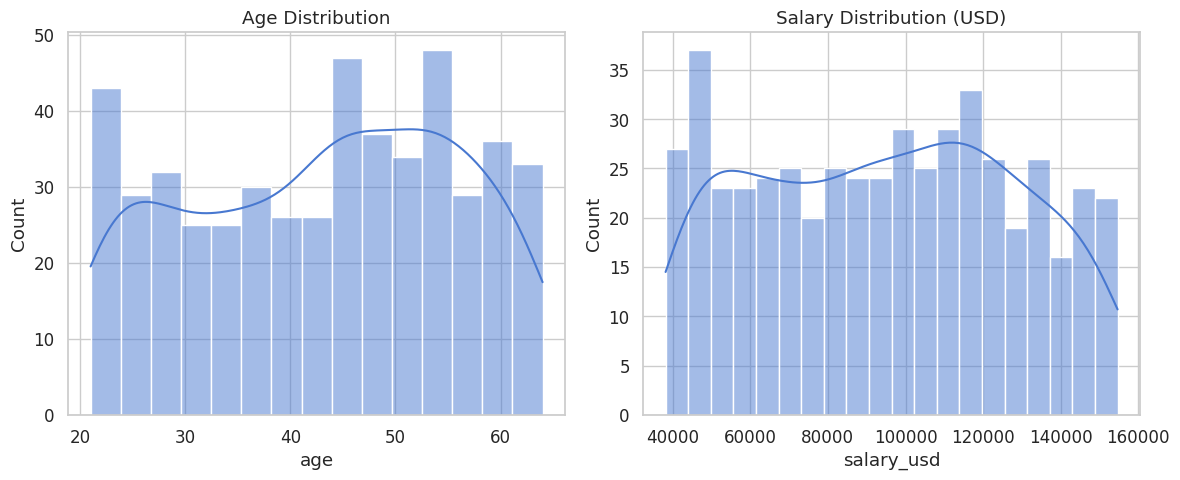

✅ Data quality visualization saved to 'figures/data_quality_distributions.png'.


In [3]:
# --- HR Analytics and Data Quality Pipeline ---
# Cell 3: Data quality checks and basic summaries
# -----------------------------------------------

# Load dataset
df_hr = pd.read_csv("data/synthetic_hr_records.csv")

print("✅ Dataset loaded successfully.")
print("Shape:", df_hr.shape)
print("\nColumn data types:")
display(df_hr.dtypes)

# --- Check for missing values ---
missing = df_hr.isnull().sum()
missing_percent = (missing / len(df_hr)) * 100
missing_summary = pd.DataFrame({
    "Missing_Values": missing,
    "Percent": missing_percent.round(2)
})
print("\n🔍 Missing Value Summary:")
display(missing_summary)

# --- Check for duplicates ---
duplicates = df_hr.duplicated().sum()
print(f"\nDuplicate records: {duplicates}")

# --- Summary statistics ---
print("\n📊 Summary Statistics:")
display(df_hr.describe(include="all"))

# --- Visualize age and salary distributions ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_hr["age"], bins=15, kde=True, ax=axes[0])
axes[0].set_title("Age Distribution")

sns.histplot(df_hr["salary_usd"], bins=20, kde=True, ax=axes[1])
axes[1].set_title("Salary Distribution (USD)")

plt.tight_layout()
plt.savefig("figures/data_quality_distributions.png", bbox_inches="tight")
plt.show()

print("✅ Data quality visualization saved to 'figures/data_quality_distributions.png'.")


In [4]:
# --- HR Analytics and Data Quality Pipeline ---
# Cell 4: Data cleaning and preprocessing
# ---------------------------------------

# Reload dataset
df_hr = pd.read_csv("data/synthetic_hr_records.csv")

print("✅ Dataset reloaded for cleaning.")
print("Initial shape:", df_hr.shape)

# --- 1. Handle duplicates ----------------------------------------------------
duplicates = df_hr.duplicated().sum()
if duplicates > 0:
    df_hr = df_hr.drop_duplicates().reset_index(drop=True)
    print(f"🧹 Removed {duplicates} duplicate records.")
else:
    print("No duplicate records found.")

# --- 2. Enforce data types ---------------------------------------------------
df_hr["employee_id"] = df_hr["employee_id"].astype(int)
df_hr["age"] = df_hr["age"].astype(int)
df_hr["tenure_years"] = df_hr["tenure_years"].astype(float)
df_hr["salary_usd"] = df_hr["salary_usd"].astype(int)

# --- 3. Outlier detection (Salary) ------------------------------------------
q1 = df_hr["salary_usd"].quantile(0.25)
q3 = df_hr["salary_usd"].quantile(0.75)
iqr = q3 - q1
lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
outliers = ((df_hr["salary_usd"] < lower_bound) | (df_hr["salary_usd"] > upper_bound)).sum()
print(f"Potential salary outliers: {outliers}")

# Optionally clip extreme values
df_hr["salary_usd"] = df_hr["salary_usd"].clip(lower_bound, upper_bound)

# --- 4. Standardize categorical text fields ---------------------------------
for col in ["department", "education", "performance_rating", "location", "gender"]:
    df_hr[col] = df_hr[col].str.strip().str.title()

# --- 5. Verify clean data ----------------------------------------------------
print("\nCleaned dataset info:")
display(df_hr.info())
display(df_hr.head())

# Save cleaned version
df_hr.to_csv("data/hr_cleaned.csv", index=False)
print("✅ Cleaned dataset saved to 'data/hr_cleaned.csv'.")

✅ Dataset reloaded for cleaning.
Initial shape: (500, 10)
No duplicate records found.
Potential salary outliers: 0

Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   employee_id         500 non-null    int64  
 1   age                 500 non-null    int64  
 2   gender              500 non-null    object 
 3   department          500 non-null    object 
 4   education           500 non-null    object 
 5   tenure_years        500 non-null    float64
 6   salary_usd          500 non-null    int64  
 7   performance_rating  500 non-null    object 
 8   location            500 non-null    object 
 9   attrition_flag      500 non-null    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 39.2+ KB


None

,employee_id,age,gender,department,education,tenure_years,salary_usd,performance_rating,location,attrition_flag
0,1001,59,Female,Hr,Associate,8.3,105821,Low,Carmel,No
1,1002,49,Female,Hr,Doctorate,7.7,75991,Meets,Bloomington,Yes
2,1003,35,Male,Sales,Master,7.2,117057,Exceeds,Carmel,No
3,1004,63,Female,Customer Support,High School,12.5,151193,Meets,Bloomington,No
4,1005,28,Male,It,Bachelor,9.1,44971,Meets,Fort Wayne,No


✅ Cleaned dataset saved to 'data/hr_cleaned.csv'.


✅ Cleaned HR dataset loaded into DuckDB.
✅ SQL queries executed successfully.


,department,employee_count
0,Finance,93
1,Sales,92
2,Hr,90
3,It,82
4,Customer Support,74


,department,avg_salary
0,Finance,96570.99
1,Customer Support,95282.61
2,Sales,95014.15
3,Hr,94598.68
4,Operations,94208.07


,department,attrition_rate
0,Finance,21.505376
1,It,17.073171
2,Hr,13.333333
3,Operations,10.144928
4,Sales,9.782609


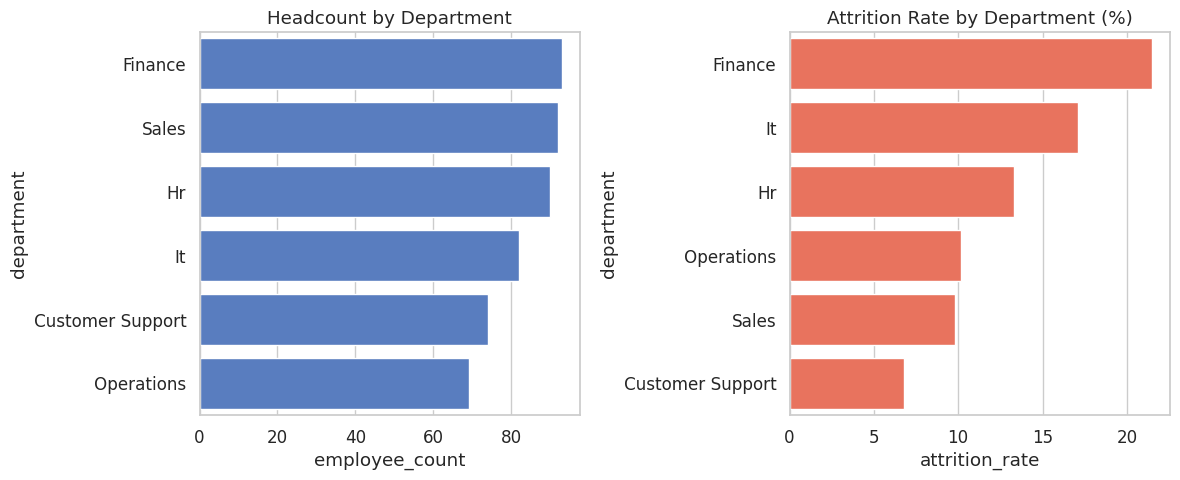

📊 Department-level visualizations saved to 'figures/hr_department_insights.png'.
💾 SQL queries saved to 'sql/hr_summary_queries.sql'.


In [5]:
# --- HR Analytics and Data Quality Pipeline ---
# Cell 5: Load cleaned HR data into DuckDB and run SQL queries
# ------------------------------------------------------------

# Reconnect to DuckDB (creates file if not present)
db_path = "data/hr_data_mart.duckdb"
con = duckdb.connect(database=db_path)

# --- 1. Load cleaned dataset into DuckDB ----------------------
df_hr = pd.read_csv("data/hr_cleaned.csv")
con.execute("CREATE OR REPLACE TABLE hr_cleaned AS SELECT * FROM df_hr")

print("✅ Cleaned HR dataset loaded into DuckDB.")

# --- 2. Example SQL queries -----------------------------------

# Headcount by department
q_dept = """
SELECT department, COUNT(*) AS employee_count
FROM hr_cleaned
GROUP BY department
ORDER BY employee_count DESC;
"""

# Average salary by department
q_salary = """
SELECT department, ROUND(AVG(salary_usd), 2) AS avg_salary
FROM hr_cleaned
GROUP BY department
ORDER BY avg_salary DESC;
"""

# Attrition rate by department
q_attrition = """
SELECT department,
       SUM(CASE WHEN attrition_flag = 'Yes' THEN 1 ELSE 0 END)*100.0/COUNT(*) AS attrition_rate
FROM hr_cleaned
GROUP BY department
ORDER BY attrition_rate DESC;
"""

# Execute and store results
dept_counts = con.execute(q_dept).fetchdf()
salary_summary = con.execute(q_salary).fetchdf()
attrition_summary = con.execute(q_attrition).fetchdf()

print("✅ SQL queries executed successfully.")
display(dept_counts.head(), salary_summary.head(), attrition_summary.head())

# --- 3. Visualization (Department Insights) -------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=dept_counts, x="employee_count", y="department", ax=axes[0])
axes[0].set_title("Headcount by Department")

sns.barplot(data=attrition_summary, x="attrition_rate", y="department", ax=axes[1], color="tomato")
axes[1].set_title("Attrition Rate by Department (%)")

plt.tight_layout()
plt.savefig("figures/hr_department_insights.png", bbox_inches="tight")
plt.show()

print("📊 Department-level visualizations saved to 'figures/hr_department_insights.png'.")

# --- 4. Save SQL scripts for reference ------------------------
os.makedirs("sql", exist_ok=True)
with open("sql/hr_summary_queries.sql", "w") as f:
    f.write("-- Headcount by department\n" + q_dept + "\n\n")
    f.write("-- Average salary by department\n" + q_salary + "\n\n")
    f.write("-- Attrition rate by department\n" + q_attrition + "\n")

print("💾 SQL queries saved to 'sql/hr_summary_queries.sql'.")


✅ HR dataset ready for exploration.
Rows: 500


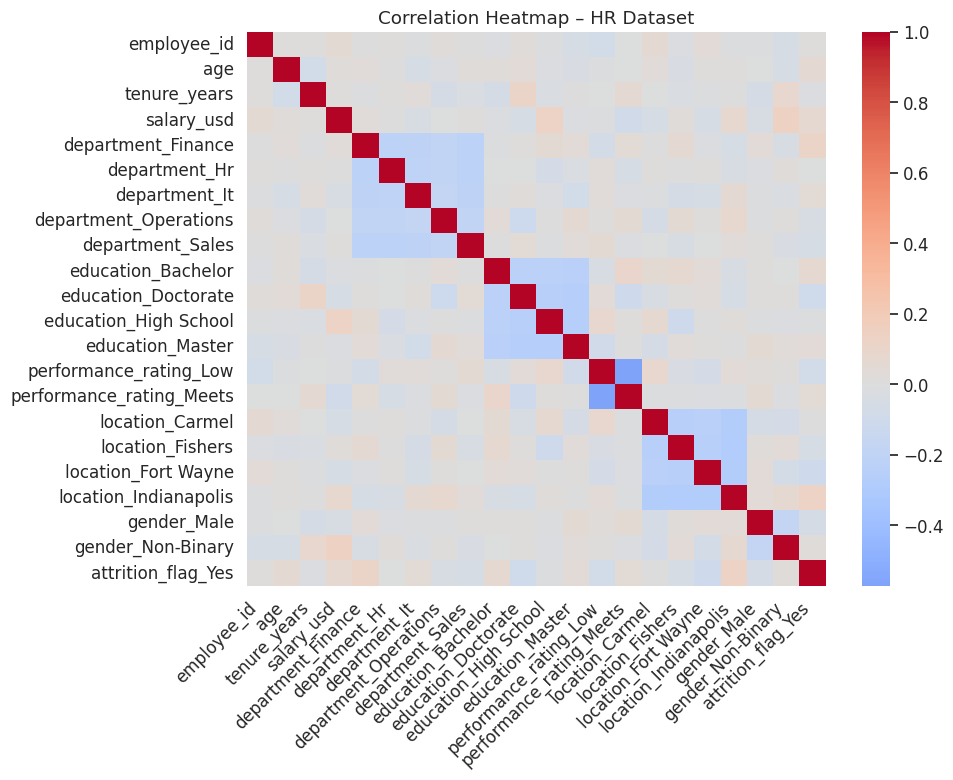

📈 Correlation heatmap saved to 'figures/hr_correlation_heatmap.png'.


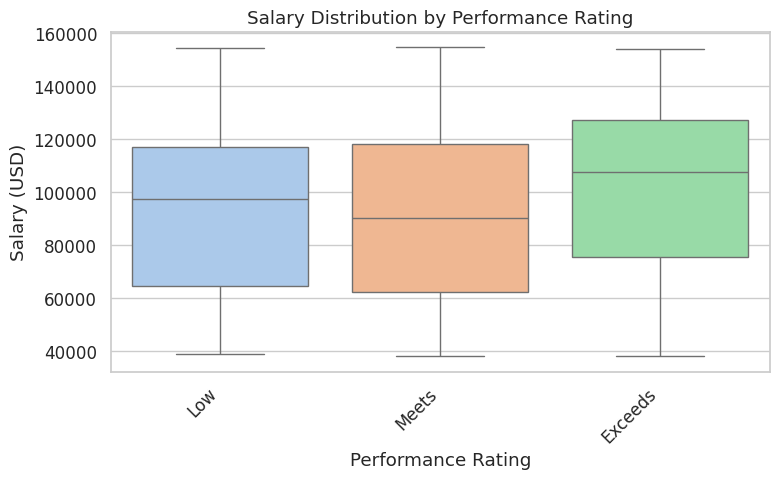

💰 Salary vs. performance visualization saved to 'figures/salary_vs_performance.png'.


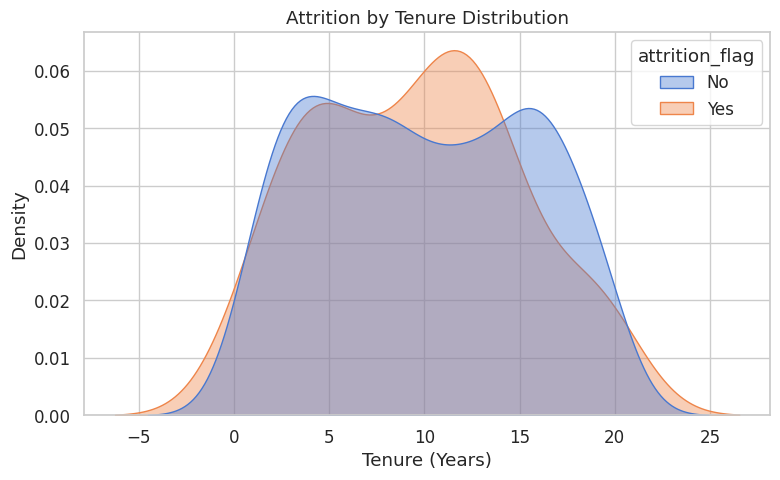

📊 Attrition by tenure visualization saved to 'figures/attrition_by_tenure.png'.


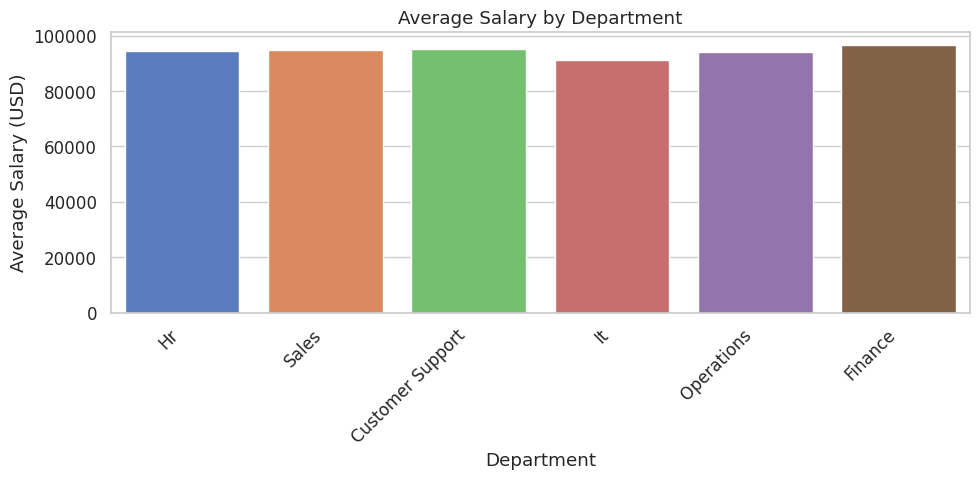

🏢 Average salary by department visualization saved to 'figures/avg_salary_by_department.png'.


In [8]:
# --- HR Analytics and Data Quality Pipeline ---
# Cell 6: Exploratory analytics and correlation insights 
# ----------------------------------------------------------------------

import warnings
warnings.filterwarnings("ignore")

# Load cleaned dataset
df_hr = pd.read_csv("data/hr_cleaned.csv")

print("✅ HR dataset ready for exploration.")
print("Rows:", len(df_hr))

# --- 1. Encode categorical features for correlation heatmap -----------------
df_encoded = df_hr.copy()
categorical_cols = ["department", "education", "performance_rating", "location", "gender", "attrition_flag"]
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)

# --- 2. Correlation heatmap --------------------------------------------------
corr = df_encoded.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap – HR Dataset")

# Rotate tick labels for readability
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("figures/hr_correlation_heatmap.png", bbox_inches="tight")
plt.show()

print("📈 Correlation heatmap saved to 'figures/hr_correlation_heatmap.png'.")

# --- 3. Salary vs. Performance Rating ---------------------------------------
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_hr, x="performance_rating", y="salary_usd", palette="pastel")
plt.title("Salary Distribution by Performance Rating")
plt.xlabel("Performance Rating")
plt.ylabel("Salary (USD)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("figures/salary_vs_performance.png", bbox_inches="tight")
plt.show()

print("💰 Salary vs. performance visualization saved to 'figures/salary_vs_performance.png'.")

# --- 4. Attrition analysis by tenure ----------------------------------------
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df_hr, x="tenure_years", hue="attrition_flag", fill=True, common_norm=False, alpha=0.4)
plt.title("Attrition by Tenure Distribution")
plt.xlabel("Tenure (Years)")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("figures/attrition_by_tenure.png", bbox_inches="tight")
plt.show()

print("📊 Attrition by tenure visualization saved to 'figures/attrition_by_tenure.png'.")

# --- 5. Department salary comparison ----------------------------------------
plt.figure(figsize=(10, 5))
sns.barplot(data=df_hr, x="department", y="salary_usd", estimator=np.mean, ci=None, palette="muted")
plt.title("Average Salary by Department")
plt.xlabel("Department")
plt.ylabel("Average Salary (USD)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("figures/avg_salary_by_department.png", bbox_inches="tight")
plt.show()

print("🏢 Average salary by department visualization saved to 'figures/avg_salary_by_department.png'.")


## 🧠 Summary and Next Steps

This notebook demonstrates an end-to-end **HR analytics and data-quality pipeline** that
cleans, validates, and explores workforce data to uncover trends in **attrition**, **salary**, and **performance**.

**Key outcomes**
- Generated a synthetic HR dataset with realistic employee attributes.  
- Performed data-quality checks for missing values, duplicates, and outliers.  
- Cleaned and standardized the dataset for analytics and SQL querying.  
- Loaded data into **DuckDB** for SQL-based summaries (headcount, salary, attrition).  
- Produced clear visualizations using **Python + Seaborn**:
  - Correlation heatmap (feature relationships)  
  - Salary vs. performance distribution  
  - Attrition by tenure patterns  
  - Department salary comparison  

**Next steps**
1. Expand dataset with additional workforce dimensions (e.g., promotions, training, engagement).  
2. Integrate **time-series analysis** to monitor attrition trends over quarters.  
3. Add **interactive dashboards** or API endpoints for live HR insights.  
4. Connect to an **S3 or Oracle data source** for larger-scale analysis.  
5. Extend Power BI integration if real data or stakeholder interest warrants it.

This project highlights how **data integrity, SQL analytics, and visualization** combine
to deliver actionable insights in an enterprise HR context.
